April

In [1]:
import os
import requests
import pandas as pd
from datetime import datetime, timedelta
import xml.etree.ElementTree as ET

# Define the start and end dates
start_date = datetime.strptime('20230916', '%Y%m%d')
end_date = datetime.strptime('20231016', '%Y%m%d')

# Define the base URL
base_url = 'https://api.data.gov.hk/v1/historical-archive/get-file?url=https%3A%2F%2Fresource.data.one.gov.hk%2Ftd%2Ftraffic-detectors%2FrawSpeedVol-all.xml&time='

# Loop over the date range
current_date = start_date
while current_date <= end_date:
    # Save the DataFrame to a CSV file
    filename = f"traffic_{current_date.strftime('%Y%m%d')}.csv"
    if os.path.isfile(filename):
        print(f"File {filename} already exists. Skipping this day.")
        current_date += timedelta(days=1)
        continue

    # Initialize a dictionary to store the total speed and count for each detector and lane
    totals = {}

    # Loop over each minute of the current day
    for minute in range(0, 24*60):
        # Generate the timestamp for the current minute
        timestamp = current_date.strftime('%Y%m%d') + '-' + f'{minute//60:02d}{minute%60:02d}'

        # Fetch the data for the current timestamp
        response = requests.get(base_url + timestamp)

        # Check the status of the response
        if response.status_code != 200:
            print(f"Failed to fetch data for {timestamp}, status code: {response.status_code}")
            continue

        root = ET.fromstring(response.content)

        # Extract the data and add it to the dictionary
        for period in root.findall('.//periods/period'):
            for detector in period.findall('.//detectors/detector'):
                detector_id = detector.find('detector_id').text

                for lane in detector.findall('.//lanes/lane'):
                    lane_id_element = lane.find('lane_id')
                    if lane_id_element is not None:
                        lane_id = lane_id_element.text
                    else:
                        print("lane_id element not found")
                        continue

                    speed_element = lane.find('speed')

                    # Check if the 'speed' element is present and contains a valid float
                    if speed_element is not None:
                        try:
                            speed = float(speed_element.text)
                        except ValueError:
                            print(f"Invalid speed: {speed_element.text}")
                            continue

                        # Add the speed to the total for the current detector and lane id
                        if (detector_id, lane_id) not in totals:
                            totals[(detector_id, lane_id)] = [speed, 1]
                        else:
                            totals[(detector_id, lane_id)][0] += speed
                            totals[(detector_id, lane_id)][1] += 1

    # Calculate the average speed for each detector and lane id and add it to the list
    data = [{'detectorID': detector_id, 'laneType': lane_id, 'speed': total_speed / count}
            for (detector_id, lane_id), (total_speed, count) in totals.items()]

    # Convert the list into a DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)
    print(f"File {filename} saved.")

    print(f"end of the day {current_date.strftime('%Y-%m-%d')}")

    # Move to the next day
    current_date += timedelta(days=1)

print(f"finished fetch")

File traffic_20230916.csv already exists. Skipping this day.
File traffic_20230917.csv already exists. Skipping this day.
File traffic_20230918.csv already exists. Skipping this day.
File traffic_20230919.csv already exists. Skipping this day.
File traffic_20230920.csv already exists. Skipping this day.
File traffic_20230921.csv already exists. Skipping this day.
File traffic_20230922.csv already exists. Skipping this day.
File traffic_20230923.csv already exists. Skipping this day.
File traffic_20230924.csv already exists. Skipping this day.
File traffic_20230925.csv already exists. Skipping this day.
File traffic_20230926.csv already exists. Skipping this day.
File traffic_20230927.csv already exists. Skipping this day.
File traffic_20230928.csv already exists. Skipping this day.
File traffic_20230929.csv already exists. Skipping this day.
File traffic_20230930.csv already exists. Skipping this day.
File traffic_20231001.csv already exists. Skipping this day.
File traffic_20231002.cs

Do the ANN Analysis,For the daily_HKO_RF_ALL.csv file and the file generated.

Score: 0.11919598090512196


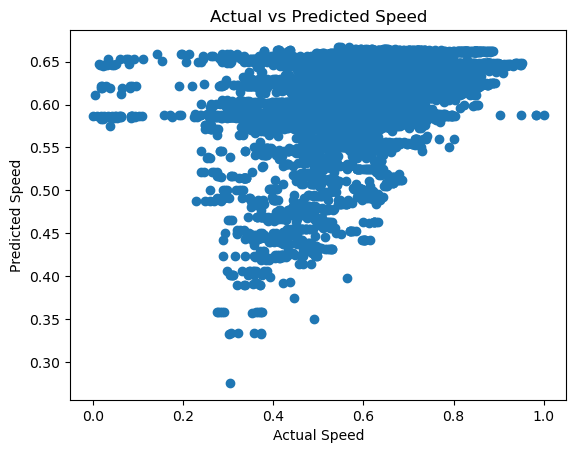

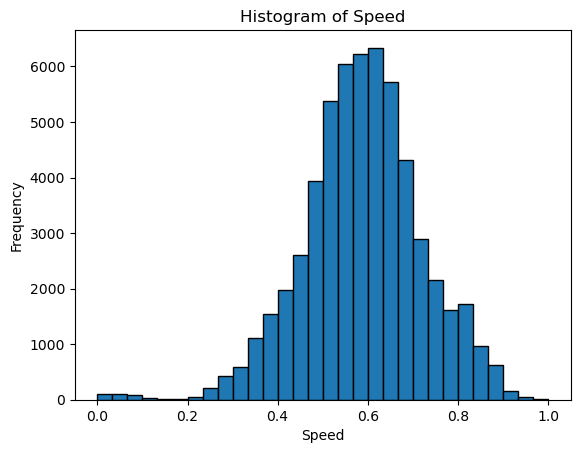

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from datetime import datetime
from sklearn.model_selection import cross_val_score

# Load the weather data, skipping the first two rows and the last four rows
weather_data = pd.read_csv('daily_HKO_RF_ALL.csv', skiprows=2, skipfooter=4, delimiter=',', on_bad_lines='skip', engine='python')

# Rename the columns to remove Chinese characters
weather_data.columns = ['Year', 'Month', 'Day', 'Value', 'Data Completeness']

# Replace 'Trace' with 0 in 'Value' column
weather_data['Value'] = weather_data['Value'].replace(['Trace'], 0)

# Drop rows with '***' in 'Value' column
weather_data = weather_data[weather_data['Value'] != '***']

# Convert 'Value' column to numeric
weather_data['Value'] = pd.to_numeric(weather_data['Value'])

# Drop rows with '***' or '#'
weather_data = weather_data[~weather_data[['Year', 'Month', 'Day']].applymap(lambda x: '***' in str(x) or '#' in str(x)).any(axis=1)]

# Convert 'Year', 'Month', 'Day' to int32
weather_data[['Year', 'Month', 'Day']] = weather_data[['Year', 'Month', 'Day']].astype(int)

# Drop 'Data Completeness' column
weather_data = weather_data.drop(columns=['Data Completeness'])

# Drop rows with missing values
weather_data = weather_data.dropna()

# Combine 'Year', 'Month', 'Day' into a single datetime column
weather_data['Date'] = pd.to_datetime(weather_data[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

# Drop 'Year', 'Month', 'Day' columns
weather_data = weather_data.drop(columns=['Year', 'Month', 'Day'])

# Define start and end dates
start_date = '20230916'
end_date = '20231016'

# Convert dates to datetime objects
start_date = datetime.strptime(start_date, '%Y%m%d')
end_date = datetime.strptime(end_date, '%Y%m%d')

# Calculate the number of days between start and end dates
num_days = (end_date - start_date).days + 1

# Load the speed data from multiple CSV files
speed_data = pd.concat([pd.read_csv(f'traffic_{(start_date + timedelta(days=i)).strftime("%Y%m%d")}.csv').assign(Date=start_date + timedelta(days=i)) for i in range(num_days)])

# Merge weather data with speed data
data = pd.merge(weather_data, speed_data, how='inner', on='Date')
data.head()
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encode 'detectorID' and 'laneType' columns
le_detectorID = LabelEncoder()
data['detectorID'] = le_detectorID.fit_transform(data['detectorID'])

le_laneType = LabelEncoder()
data['laneType'] = le_laneType.fit_transform(data['laneType'])

# Normalize the 'Value' and 'speed' columns
scaler = MinMaxScaler()
data[['Value', 'speed']] = scaler.fit_transform(data[['Value', 'speed']])

# Split the data into input (X) and output (y)
X = data.drop(['speed', 'Date'], axis=1)
y = data['speed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

# Define the ANN model architecture
model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', solver='adam', max_iter=50, random_state=26)

# Perform 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print('Score:', score)

# Use the trained model to make predictions
predictions = model.predict(X_test)

# Plot actual vs predicted values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Actual vs Predicted Speed')
plt.show()
# Plot a histogram of the 'speed' column
plt.hist(data['speed'], bins=30, edgecolor='black')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Histogram of Speed')
plt.show()

 **Outliers or High Leverage Points:** If there are a few extreme values in your data, they could be pulling the line of best fit towards them, causing the rest of the points to appear concentrated in the center.

In [3]:
# Let's say we want to predict the speed for the following conditions:
# detectorID = 'AID01101', laneType = 'Fast Lane', Value = 0.0
# Transform these values in the same way as the training data
detectorID_encoded = le_detectorID.transform(['AID04111'])
laneType_encoded = le_laneType.transform(['Fast Lane'])
# Transform 'Value' in the same way as the training data
Value_normalized = scaler.transform([[0.0, 0.0]])  # Add a dummy value to make it a 2D array

# Only use the first column (the normalized 'Value') for the new data
new_data = pd.DataFrame({
    'Value': Value_normalized[:, 0],  # Only use the first column
    'detectorID': detectorID_encoded,
    'laneType': laneType_encoded
})

# And finally, we can use the trained model to make a prediction
new_prediction = model.predict(new_data)
print('Predicted Speed:', new_prediction)

Predicted Speed: [0.65975648]


/Users/troyfung/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


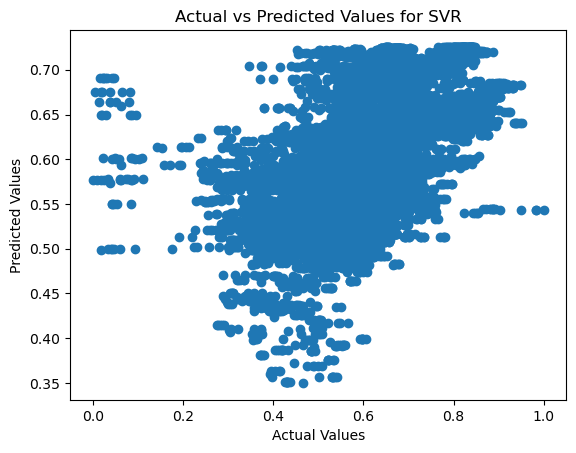

R^2 score: 0.2574283300065212


In [4]:
from sklearn.svm import SVR

# Create a SVR model with radial basis function (rbf) kernel
modelSVR = SVR(kernel='rbf')

# Train the model
modelSVR.fit(X_train, y_train)

# Make predictions on the test set
y_pred = modelSVR.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for SVR')
plt.show()
from sklearn.metrics import r2_score


# Compute the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 score: {r2}')

In [5]:
# Let's say we want to predict the speed for the following conditions:
# detectorID = 'AID01101', laneType = 'Fast Lane', Value = 0.0
# Transform these values in the same way as the training data
detectorID_encoded = le_detectorID.transform(['AID01111'])
laneType_encoded = le_laneType.transform(['Fast Lane'])
# Transform 'Value' in the same way as the training data
Value_normalized = scaler.transform([[360.0, 0.0]])  # Add a dummy value to make it a 2D array

# Only use the first column (the normalized 'Value') for the new data
new_data = pd.DataFrame({
    'Value': Value_normalized[:, 0],  # Only use the first column
    'detectorID': detectorID_encoded,
    'laneType': laneType_encoded
})

# And finally, we can use the trained SVM model to make a prediction
new_prediction = modelSVR.predict(new_data)
print('Predicted Speed:', new_prediction)

Predicted Speed: [0.44976989]


/Users/troyfung/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
